In [1]:
from tf_pwa.config_loader import ConfigLoader
from tf_pwa.amp.core import Particle
from tf_pwa.experimental import extra_amp
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt

2025-09-02 15:05:53.084014: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-02 15:05:53.084232: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 15:05:53.146027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-02 15:05:55.132068: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

No module named 'uproot' you should install `uproot` correctly for using this module


In [134]:
# Loading config files
config = ConfigLoader("config_a.yml")
config.set_params("final_params.json")

# Sampling four-vectors
p4 = config.generate_phsp_p(100000) # <-- number of sampled four-vectors
data = config.data.cal_angle(p4)

# Creating and model
amp_model = config.get_amplitude()
dg = amp_model.decay_group

/home/akazatsky/Desktop/CompProject/New/B2DxDK/tf-pwa/tf_pwa/amp/core.py:138: UserWarning: No model named C(BWR_LS) found, use default instead.
  warnings.warn(
/home/akazatsky/Desktop/CompProject/New/B2DxDK/tf-pwa/tf_pwa/amp/core.py:138: UserWarning: No model named C(BWR) found, use default instead.
  warnings.warn(
/home/akazatsky/Desktop/CompProject/New/B2DxDK/tf-pwa/tf_pwa/amp/core.py:138: UserWarning: No model named C(PsiKmatrix) found, use default instead.
  warnings.warn(
/home/akazatsky/Desktop/CompProject/New/B2DxDK/tf-pwa/tf_pwa/amp/core.py:138: UserWarning: No model named C(New) found, use default instead.
  warnings.warn(
/home/akazatsky/Desktop/CompProject/New/B2DxDK/tf-pwa/tf_pwa/amp/core.py:138: UserWarning: No model named C(one) found, use default instead.
  warnings.warn(
/home/akazatsky/Desktop/CompProject/New/B2DxDK/tf-pwa/tf_pwa/amp/core.py:138: UserWarning: No model named C2(BWR) found, use default instead.
  warnings.warn(
/home/akazatsky/Desktop/CompProject/New/B

In [135]:
# Which resonances
count = 0
for i in range(len(dg.chains)):
    print(count, ':', dg.chains[i][0])
    count += 1

0 : Bp->Zc(3900)+K
1 : Bp->X(3872)+K
2 : Bp->X(3915)(0-)+K
3 : Bp->chi(c2)(3930)+K
4 : Bp->X(3940)(1+)+K
5 : Bp->X(3993)+K
6 : Bp->XDstD1pp+K
7 : Bp->X(4020)+K
8 : Bp->Psi(4040)+K
9 : Bp->Zc(4200)+K
10 : Bp->X(4100)+K
11 : Bp->all_psi+K
12 : Bp->chi(c1)(4274)+K
13 : Bp->X(4300)+K
14 : Bp->Psi(4415)+K
15 : Bp->Zc(4430)+K
16 : Bp->X(4600)+K
17 : Bp->XDstD_Scan+K
18 : Bp->NR(0-)SPp+K
19 : Bp->NR(1-)PPp+K
20 : Bp->NR(1+)PSp+K
21 : Bp->NR(0-)SPm+K
22 : Bp->NR(1-)PPm+K
23 : Bp->NR(1+)PSm+K
24 : Bp->X0(2900)+Dst
25 : Bp->X1(2900)+Dst


In [195]:
paper = [0, 1, 3, 4, 7, 8, 12, 15, 18, 19, 20, 21, 22, 23, 24, 25]

In [196]:
for i in paper:
    print(count, ':', dg.chains[i][0])

26 : Bp->Zc(3900)+K
26 : Bp->X(3872)+K
26 : Bp->chi(c2)(3930)+K
26 : Bp->X(3940)(1+)+K
26 : Bp->X(4020)+K
26 : Bp->Psi(4040)+K
26 : Bp->chi(c1)(4274)+K
26 : Bp->Zc(4430)+K
26 : Bp->NR(0-)SPp+K
26 : Bp->NR(1-)PPp+K
26 : Bp->NR(1+)PSp+K
26 : Bp->NR(0-)SPm+K
26 : Bp->NR(1-)PPm+K
26 : Bp->NR(1+)PSm+K
26 : Bp->X0(2900)+Dst
26 : Bp->X1(2900)+Dst


In [136]:
# Included resonance number(s)
R = [11,12] # [0]: X(3872), [1]: X(3915), [2]: chi(c2)(3930), ..., [0,1]: X(3872) and X(3915), ...

# Modifying model
dg.set_used_chains(R)

# Executing amplitude calculation
amps = dg.get_amp(data).numpy()

# Which decays
for i in R:
    print(dg[i])
print()

# Which end products
print(p4.keys())

[Bp->all_psi+K, all_psi->Dst+D, Dst->D0+pi]
[Bp->chi(c1)(4274)+K, chi(c1)(4274)->Dst+D, Dst->D0+pi]

dict_keys([D, D0, K, pi])


In [198]:
# Filling JSON file with amplitudes
all_amps = []

for i in range(len(dg.chains)):
    amp_model = config.get_amplitude()
    dg = amp_model.decay_group

    dg.set_used_chains([i])

    amps = dg.get_amp(data).numpy().flatten()

    amps_sep = []
    for j in amps:
        amps_sep.append([float(j.real), float(j.imag)])

    all_amps.append(amps_sep)

with open('all_amps.json', 'w') as f:
    json.dump(all_amps, f, indent=2)

In [138]:
# Dalitz plot
def inv_mass_squared(p1, p2):
    E = p1[:, 0] + p2[:, 0]
    px = p1[:, 1] + p2[:, 1] 
    py = p1[:, 2] + p2[:, 2]
    pz = p1[:, 3] + p2[:, 3]
    return E**2 - (px**2 + py**2 + pz**2)

p4_str = {str(k): v for k, v in p4.items()}


I = np.abs(amps)**2
I = I.flatten()

p_D, p_D0, p_K, p_pi = p4_str['D'], p4_str['D0'], p4_str['K'], p4_str['pi']

p_Dst = p_D0 + p_pi

m2_DstD = inv_mass_squared(p_Dst, p_D)
m2_DstK = inv_mass_squared(p_Dst, p_K)
m2_DK = inv_mass_squared(p_D, p_K)

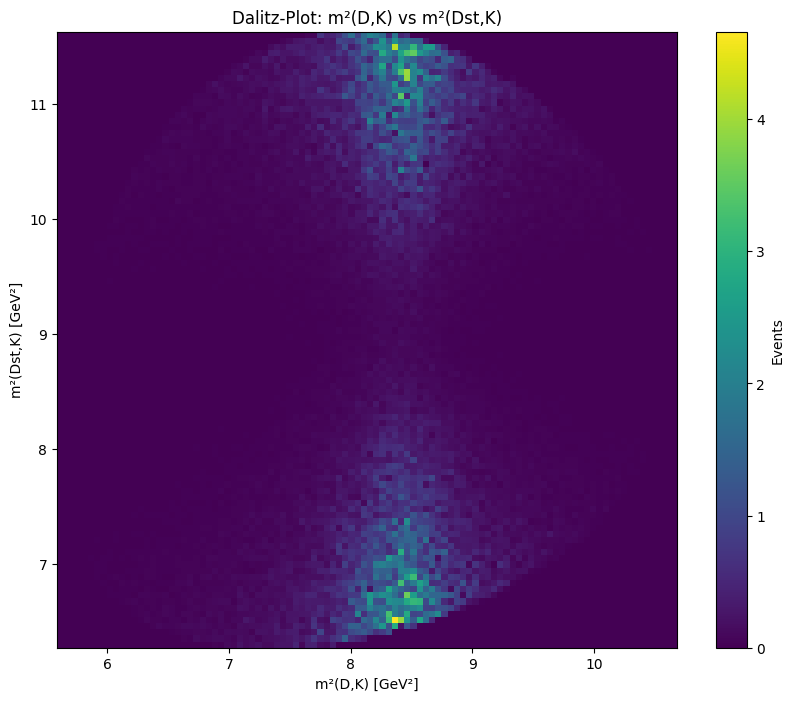

In [139]:
plt.figure(figsize=(10, 8))
plt.hist2d(m2_DK, m2_DstK, bins=100, weights=I, cmap='viridis')
plt.colorbar(label='Events')
plt.xlabel('m²(D,K) [GeV²]')
plt.ylabel('m²(Dst,K) [GeV²]')
plt.title('Dalitz-Plot: m²(D,K) vs m²(Dst,K)')
plt.show()

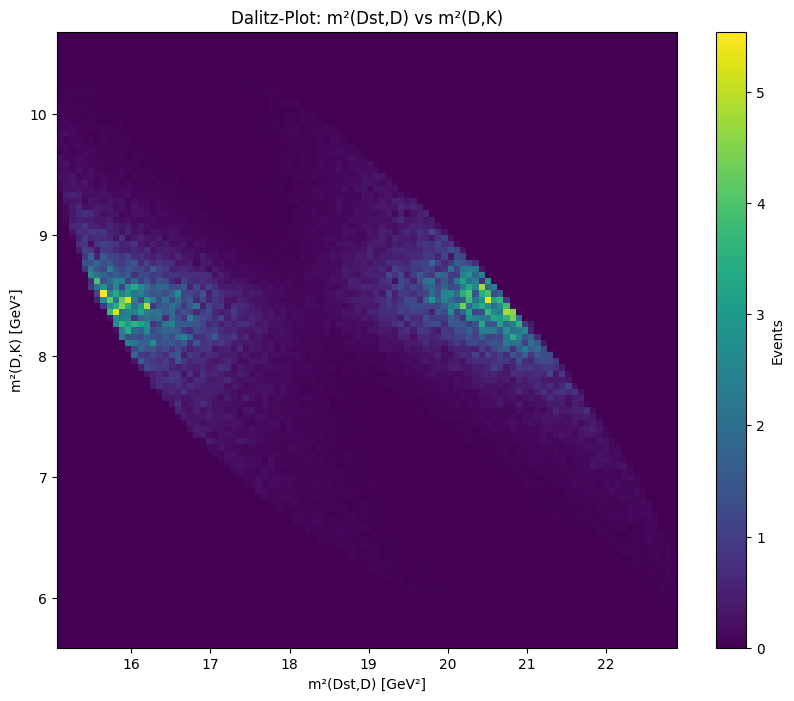

In [140]:
plt.figure(figsize=(10, 8))
plt.hist2d(m2_DstD, m2_DK, bins=100, weights=I, cmap='viridis')
plt.colorbar(label='Events')
plt.xlabel('m²(Dst,D) [GeV²]')
plt.ylabel('m²(D,K) [GeV²]')
plt.title('Dalitz-Plot: m²(Dst,D) vs m²(D,K)')
plt.show()

In [113]:
print(I.shape)

(100000,)


/tmp/ipykernel_12986/1445174976.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("plasma", n_resonances)


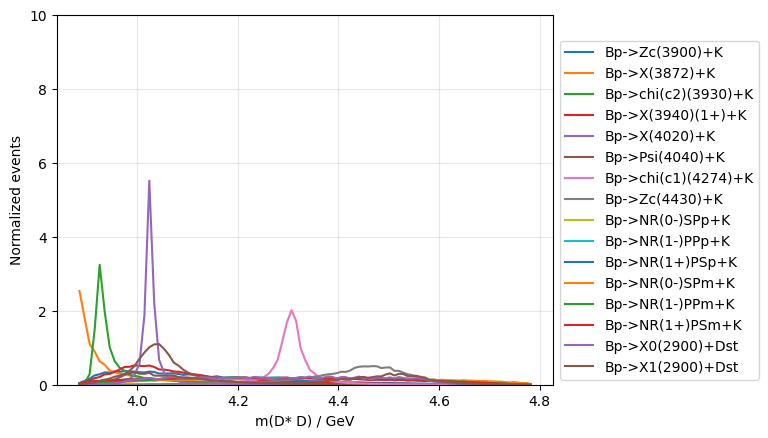

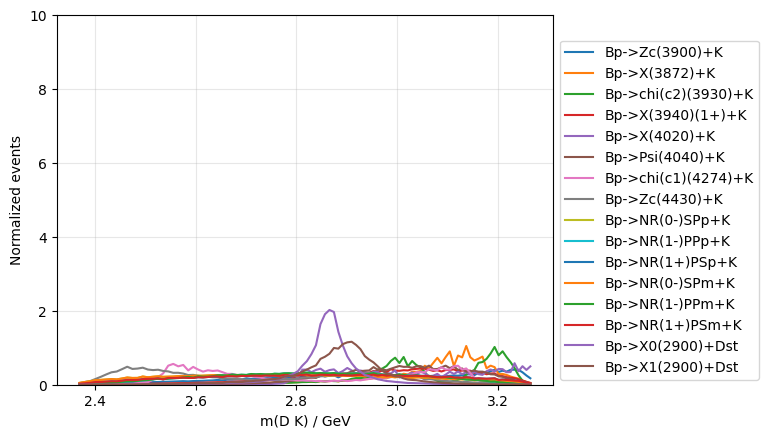

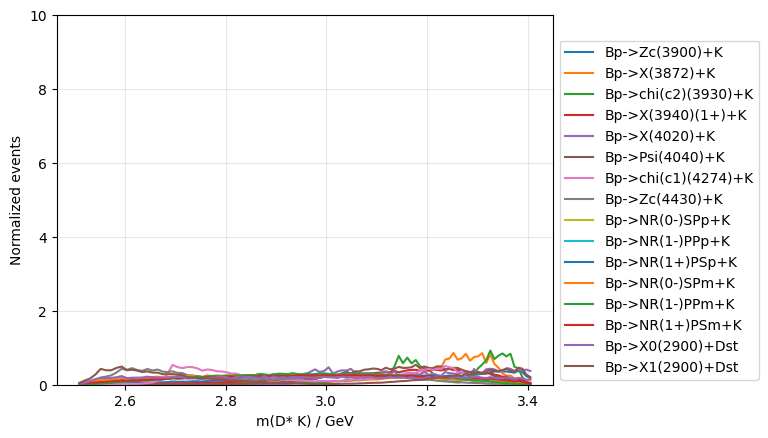

In [197]:
# Plotting of all mass spectra

#n_resonances = len(all_amps)
n_resonances = len(paper)
n_events = len(all_amps[0])

amps_array = np.zeros((n_resonances, n_events), dtype=np.complex128)

#for i in range(n_resonances):
for i in paper:
    for j in range(n_events):
        re, im = all_amps[i][j]
        amps_array[paper.index(i), j] = re + 1j*im

weights = np.abs(amps_array)**2

m = [m2_DstD, m2_DK, m2_DstK]
m_names = ["m(D* D)", "m(D K)", "m(D* K)"]

Hist = []
cmap = plt.cm.get_cmap("plasma", n_resonances)
colors = [cmap(i) for i in range(n_resonances)]

for M in range(len(m)):
    for res in range(len(weights)):
        hist, edges = np.histogram(m[M], bins=100, weights=weights[res], density=True)
        Hist.append(hist)
        #err  = np.sqrt(np.histogram(masses, bins=edges, weights=weights**2)[0][0])
        bin_centers = np.sqrt(0.5*(edges[1:] + edges[:-1]))
        plt.plot(bin_centers, hist, label=dg.chains[paper[res]][0])#, color=colors[res])

    # res_sums = []
    # for b in range(100):
    #     sum = 0
    #     for r in range(n_resonances):
    #         sum += Hist[r][b]

    #     res_sums.append(sum)

    #plt.plot(bin_centers, res_sums, label="Sum", color="b")
    plt.legend(bbox_to_anchor=(1, 0.95))
    plt.grid(alpha=0.3)
    plt.xlabel(f"{m_names[M]} / GeV")
    plt.ylabel("Normalized events")
    plt.ylim(0, 10)
    plt.show()

In [172]:
for i in range(13):
    print(dg.chains[i][0], f":   {bin_centers[np.argmax(Hist[i])]: .4} GeV   ", np.max(Hist[i]))

Bp->Zc(3900)+K :    3.885 GeV    2.5377629336750163
Bp->X(3872)+K :    3.975 GeV    0.373944520203456
Bp->X(3915)(0-)+K :    3.926 GeV    3.246275397432596
Bp->chi(c2)(3930)+K :    3.995 GeV    0.5250775255293421
Bp->X(3940)(1+)+K :    4.024 GeV    5.521433599026318
Bp->X(3993)+K :    4.044 GeV    1.0984241309176612
Bp->XDstD1pp+K :    4.307 GeV    2.0166449099754047
Bp->X(4020)+K :    4.468 GeV    0.5029447014662792
Bp->Psi(4040)+K :    4.379 GeV    0.183696781786736
Bp->Zc(4200)+K :    4.187 GeV    0.201449048998254
Bp->X(4100)+K :    4.196 GeV    0.19839707891809838
Bp->all_psi+K :    4.379 GeV    0.18369678178673618
Bp->chi(c1)(4274)+K :    4.187 GeV    0.2014490489982541
